# <center>Conformal Prediction of Stock Prices</center>
This project examines Stock prices of the XXX stock for the period YYY, then tries to predict their future prices using traditional methods such as ARIMA modelling.  Additionally, we use Conformal prediction to ascertain the accuracy of the prediction




Date: April 9th, 2024



Authors: Rohit Vernekar & A. Walker


# <center>Abstract</center>

The price of a stock indicates its current value to buyers and sellers. It gives insight into a company's current market value.  However, the stock's intrinsic value may be higher or lower.
A stock investor identifies undervalued stocks to be able to take advantage of favourable price changes in the future.
In this presentation, we examine Stock prices to find a model that could predict the future prices to a great degree of accuracy.  We incorporate the use of Conformal Prediction to establish bounds on the predictions


# Table of Contents
* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
* [Chapter 3](#chapter3)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)

#<center>Introduction</center>
We model stock prices, fine tune the model by utilizing Statistical techniques taught in class such as ... to ensure that the model fits the data.  Then Conformal prediction is used to create statistically rigorous uncertainty sets/intervals for the predictions of the above mentioned model. The sets are valid in a distribution-free sense: they possess explicit, non-asymptotic guarantees even without distributional assumptions or model assumptions. Conformal prediction will be used to produce sets that are guaranteed to contain the true values with a user-specified probability, such as 90%. Though typically Conformal Predicction is used on Exchangeable data, of which Time Series certainly is not, in this paper we discuss ways to mitigate the Exchangeable data challenge to adapt Conformal Prediction to be effective



#<center>Methods</center>

What did you do? – a section which details how the research was performed.  
It typically features a description of the participants/subjects that were involved, the study design, 
the materials that were used, and the study procedure.  
If there were multiple experiments, then each experiment may require a separate Methods section. 
A rule of thumb is that the Methods section should be sufficiently detailed for another researcher 
to duplicate your research.


#<center>Results</center>

#<center>Discussion</center>

#<center>References</center>

#<center>Tables and Figures</center>

#<center>Appendix</center>

In [2]:
# import libraries
import sklearn
import time 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
#check for outliers in the data, remove anything more that 3 std dev away
def testOutlierRemovalAndIdentification(time_series_data):
    # Calculate z-scores for each data point
    z_scores = (time_series_data - time_series_data.mean()) / time_series_data.std()

    # Define a threshold for outlier detection (e.g., z-score > 3 or < -3)
    outlier_threshold = 3

    # Identify outliers
    outliers = time_series_data[abs(z_scores) > outlier_threshold]

    # Remove outliers from the time series data
    filtered_data = time_series_data.drop(outliers.index)

    # Plot the original time series data and the filtered data
    plt.figure(figsize=(10, 6))
    plt.plot(time_series_data.index, time_series_data, label='Original Data', color='blue')
    plt.scatter(outliers.index, outliers, color='red', label='Outliers')
    plt.plot(filtered_data.index, filtered_data, label='Filtered Data', color='green')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Data with Outliers Removed')
    plt.legend()
    plt.show()

    # Print the number of removed outliers
    print(f"Number of removed outliers: {len(outliers)}")
    return filtered_data

In [36]:
# do some differencing followed by pValue stationarity test with both ADF and KPSS
def differencedData(dataToTest, differencedN):
    diffData = dataToTest.diff(differencedN)
    return diffData
    

In [38]:

# test for Stationarity by executing Augmented DickeyFuller test, p-value < 0.05 will indicate stationarity
def stationarityTest(dataToTest):
    # adftest = adfuller(data['GDP'], autolag='AIC', regression='ct')
    adftest = adfuller(dataToTest, autolag='AIC', regression='ct')
    print("ADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: A P-Value less than 0.05, results in rejecting the null hypothesis, conclusion the series is stationary")

# Test Stationarity by performing the KPSS test, a p-value > 0.05 will indicate stationarity
def stationarityKPSS(dataToTest):
    result = kpss(dataToTest.squeeze())
    # result = kpss(dataToTest, regression='c')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critical Vals:')
        print(f'   {key}, {value}')
    print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

# test ACF to check stationarity
def plotACF(dataToTest, tickerName = ""):
    # plot_acf(data['GDP'], lags=20)
    plot_acf(dataToTest, lags=20)
    plt.title("Autocorrelation Function (ACF) " + tickerName )
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

In [3]:
# grid searching features below

import warnings
warnings.filterwarnings("ignore")

# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
# from pandas import datetime
from datetime import datetime
from pandas import Timestamp
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

def fitStatistics(model_fit):
    # summary of fit model
    print(model_fit.summary())
    # residuals line plot
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    pyplot.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    pyplot.show()
    # residuals summary statistics
    print(residuals.describe())

# evaluate an ARIMA model for any order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset 
    # maybe take this out of function and feed into function via arguments
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train] # create a list of data points and store in history
	# create a list to store predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [4]:
from datetime import date
from datetime import datetime as dt
import pytz
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [8]:
tz = pytz.timezone("America/New_York")
data = {}
stock_list = ['AAPL', 'AMZN', '^GSPC', 'CTSH']
start = tz.localize(dt(2020,4,1))
end = tz.localize(dt(2024, 3, 31))


market_data = yf.download (tickers = '^GSPC', start = start, end = end, interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
data['^GSPC'] = {'name': '^GSPC', 'dataValue': market_data}
print('\n^GSPC market data sample')
print(market_data.head())

ctsh_market_data = yf.download (tickers = 'CTSH', start = start, end = end, interval = "1d") # start="1927-12-30"
ctsh_market_data["pct_change"] = ctsh_market_data["Close"].pct_change()
ctsh_market_data['date_ordinal'] = pd.to_datetime(ctsh_market_data.index.to_series()).apply(lambda date: date.toordinal())
data['CTSH'] = {'name': 'CTSH', 'dataValue': ctsh_market_data}
print('\nCTSH market data sample')
print(ctsh_market_data.head())

amzn_market_data = yf.download (tickers = 'AMZN', start = start, end = end, interval = "1d") # start="1927-12-30"
amzn_market_data["pct_change"] = amzn_market_data["Close"].pct_change()
amzn_market_data['date_ordinal'] = pd.to_datetime(amzn_market_data.index.to_series()).apply(lambda date: date.toordinal())
data['AMZN'] = {'name': 'AMZN', 'dataValue': amzn_market_data}
print('\nAMZN market data sample')
print(amzn_market_data.head())

aapl_market_data = yf.download (tickers = 'AAPL', start = start, end = end, interval = "1d") # start="1927-12-30"
aapl_market_data["pct_change"] = aapl_market_data["Close"].pct_change()
aapl_market_data['date_ordinal'] = pd.to_datetime(aapl_market_data.index.to_series()).apply(lambda date: date.toordinal())
data['AAPL'] =  {'name': 'AAPL', 'dataValue': aapl_market_data}
print('\nAAPL market data sample')
print(aapl_market_data.head())

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


^GSPC market data sample
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-04-01  2498.080078  2522.750000  2447.489990  2470.500000  2470.500000   
2020-04-02  2458.540039  2533.219971  2455.790039  2526.899902  2526.899902   
2020-04-03  2514.919922  2538.179932  2459.959961  2488.649902  2488.649902   
2020-04-06  2578.280029  2676.850098  2574.570068  2663.679932  2663.679932   
2020-04-07  2738.649902  2756.889893  2657.669922  2659.409912  2659.409912   

                Volume  pct_change  date_ordinal  
Date                                              
2020-04-01  5964000000         NaN        737516  
2020-04-02  6464190000    0.022829        737517  
2020-04-03  6096970000   -0.015137        737518  
2020-04-06  6403840000    0.070331        737521  
2020-04-07  7050410000   -0.001603        737522  

CTSH market data sample
                 Open       High      

In [ ]:
# now run some stationarity tests, FOR ADF p-value less than 0.05 indicates stationarity.  for KPSS the opposite is true
stationarityKPSS(ctsh_market_data["Adj Close"])
stationarityTest(ctsh_market_data["Adj Close"])
plotACF(ctsh_market_data["Adj Close"], data['CTSH']['name'])
    

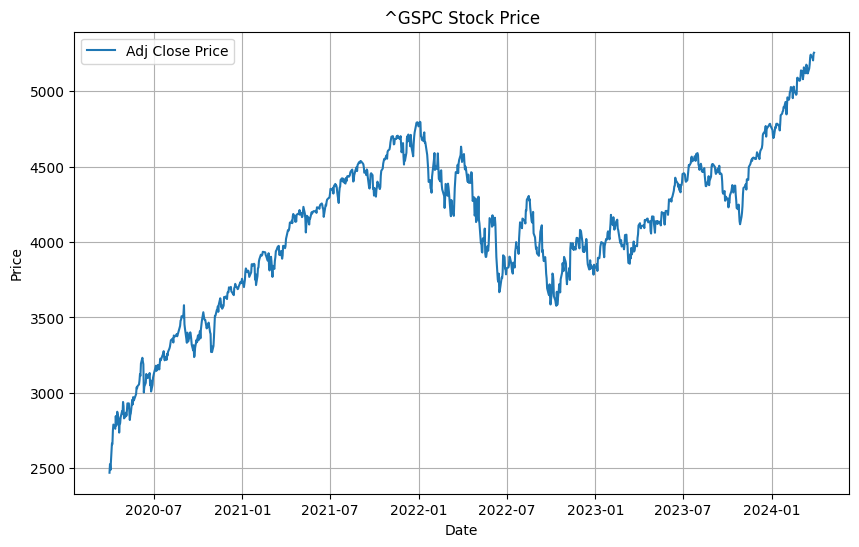

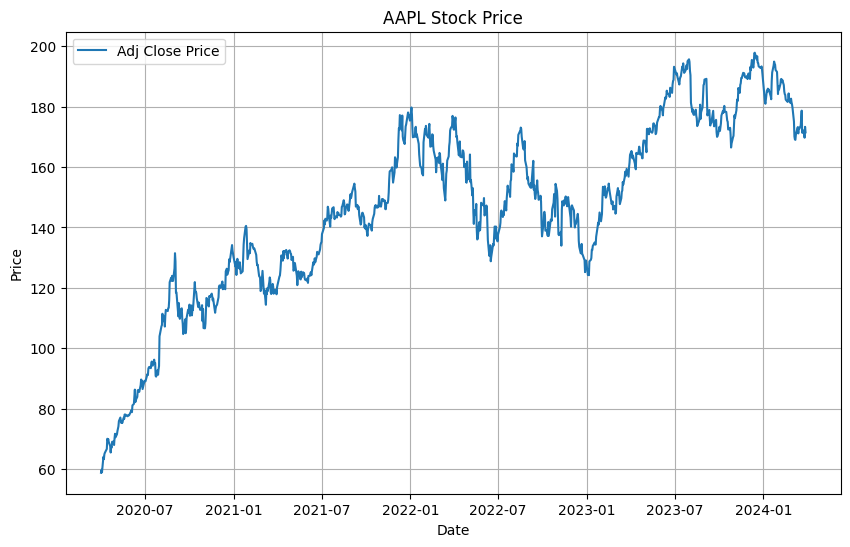

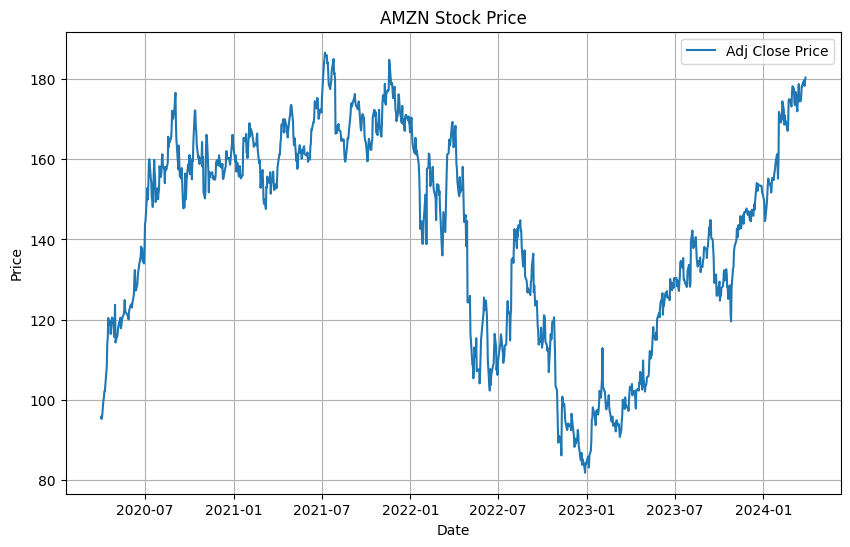

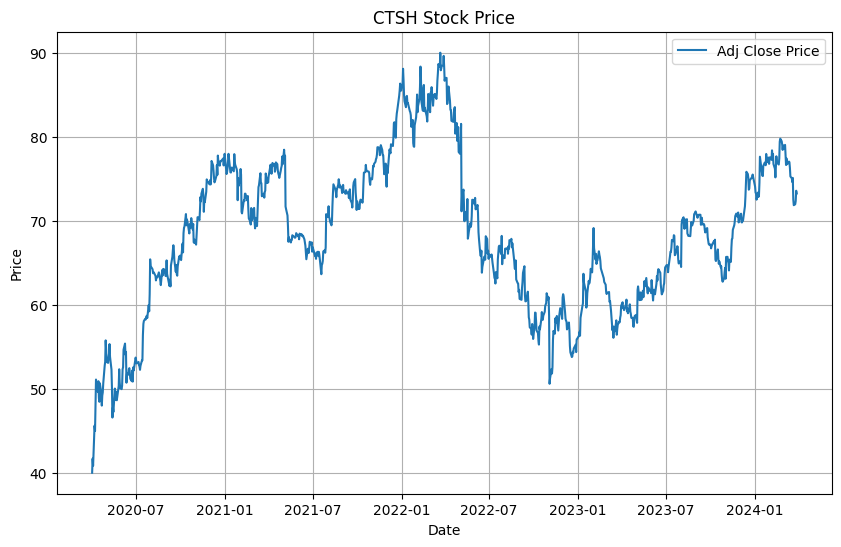

In [28]:
# Plot the 'Adj Close' price of the stock
def plotStockClosePrice(stockData, tickerSymbol, position):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(stockData['Adj Close'], label='Adj Close Price')
    plt.title(f'{tickerSymbol} Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    # fig.add_subplot(position)   
    
plotStockClosePrice(market_data, '^GSPC', 221)  #top left
plotStockClosePrice(aapl_market_data, 'AAPL', 222)
plotStockClosePrice(amzn_market_data, 'AMZN', 223)
plotStockClosePrice(ctsh_market_data, 'CTSH', 224)
plt.show()



In [44]:
# plot pacf and eacf here 
from statsmodels.tsa.stattools import eacf
# test ACF to check stationarity
def plotACF(dataToTest, tickerName = ""):
    plot_acf(data['GDP'], lags=20)
    plt.title("Autocorrelation Function (ACF) " + tickerName )
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()
    
def plotPACF(dataToTest, tickerName = ""):
    plot_pacf(dataToTest, lags=20)
    plt.title("(PACF) " + tickerName )
    plt.xlabel("Lags")
    plt.ylabel("PACF Value")
    plt.show()

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -32.36681350195545
P-Value: 0.0
Number of lags: 0
Number of observations: 1003
Critical Values: {'1%': -3.967824413085508, '5%': -3.4148762951904854, '10%': -3.129631790136133}
Note: A P-Value less than 0.05, results in rejecting the null hypothesis, conclusion the series is stationary

Now print the KPSS statistics

KPSS Statistic: 0.231053
p-value: 0.100000
Critical Vals:
   10%, 0.347
Critical Vals:
   5%, 0.463
Critical Vals:
   2.5%, 0.574
Critical Vals:
   1%, 0.739
KPSS test:	p-value: 0.100


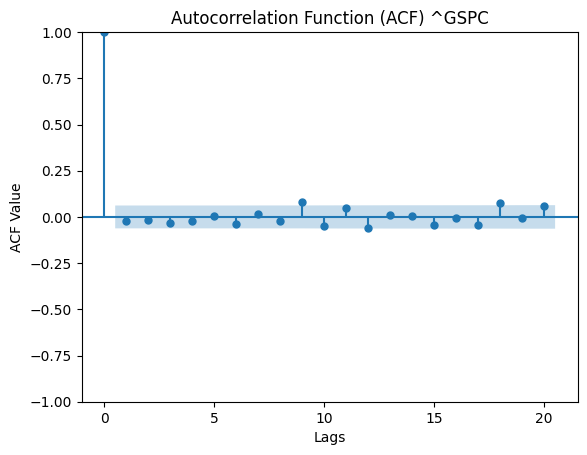

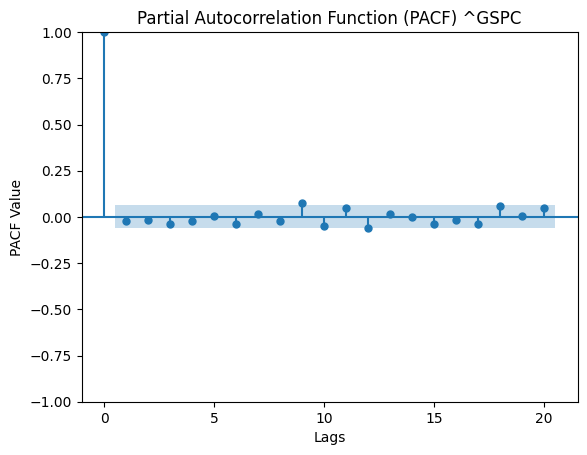

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -10.636366270318435
P-Value: 1.134171957818744e-16
Number of lags: 8
Number of observations: 995
Critical Values: {'1%': -3.9678974435788446, '5%': -3.4149116354152773, '10%': -3.129652580230259}
Note: A P-Value less than 0.05, results in rejecting the null hypothesis, conclusion the series is stationary

Now print the KPSS statistics

KPSS Statistic: 0.243559
p-value: 0.100000
Critical Vals:
   10%, 0.347
Critical Vals:
   5%, 0.463
Critical Vals:
   2.5%, 0.574
Critical Vals:
   1%, 0.739
KPSS test:	p-value: 0.100


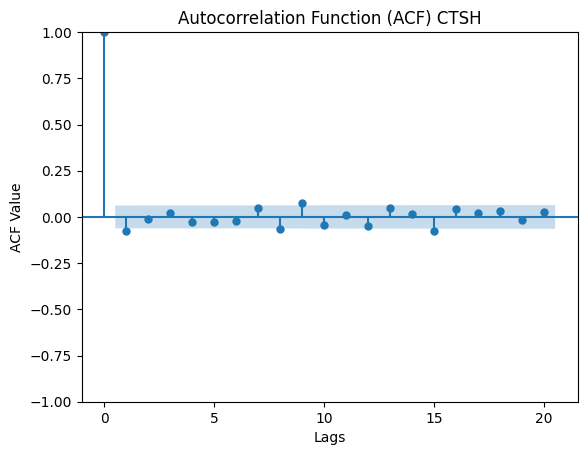

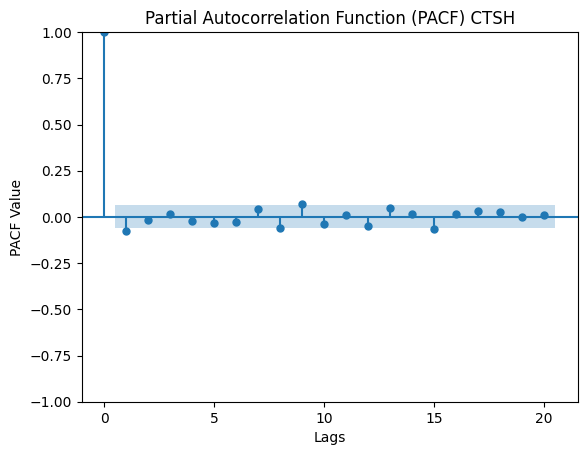

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -31.83301849541918
P-Value: 0.0
Number of lags: 0
Number of observations: 1003
Critical Values: {'1%': -3.967824413085508, '5%': -3.4148762951904854, '10%': -3.129631790136133}
Note: A P-Value less than 0.05, results in rejecting the null hypothesis, conclusion the series is stationary

Now print the KPSS statistics

KPSS Statistic: 0.194717
p-value: 0.100000
Critical Vals:
   10%, 0.347
Critical Vals:
   5%, 0.463
Critical Vals:
   2.5%, 0.574
Critical Vals:
   1%, 0.739
KPSS test:	p-value: 0.100


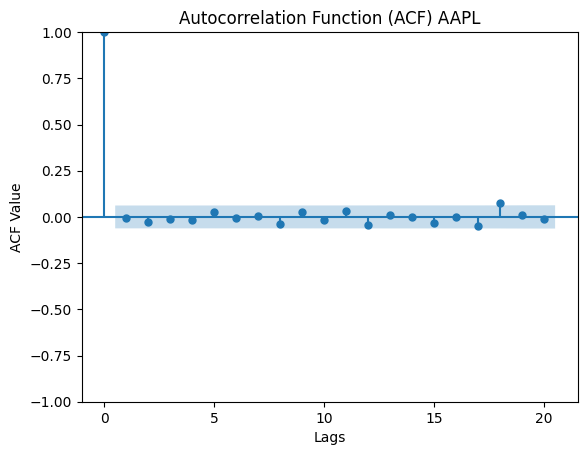

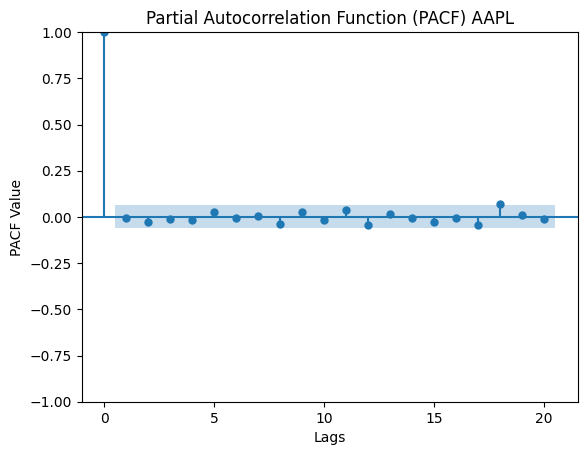

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -31.94724200576524
P-Value: 0.0
Number of lags: 0
Number of observations: 1003
Critical Values: {'1%': -3.967824413085508, '5%': -3.4148762951904854, '10%': -3.129631790136133}
Note: A P-Value less than 0.05, results in rejecting the null hypothesis, conclusion the series is stationary

Now print the KPSS statistics

KPSS Statistic: 0.180045
p-value: 0.100000
Critical Vals:
   10%, 0.347
Critical Vals:
   5%, 0.463
Critical Vals:
   2.5%, 0.574
Critical Vals:
   1%, 0.739
KPSS test:	p-value: 0.100


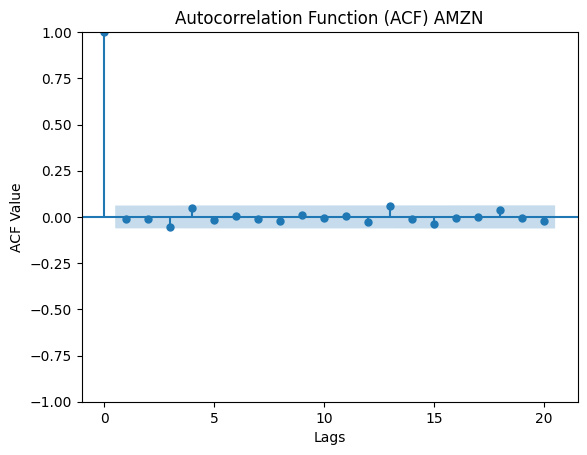

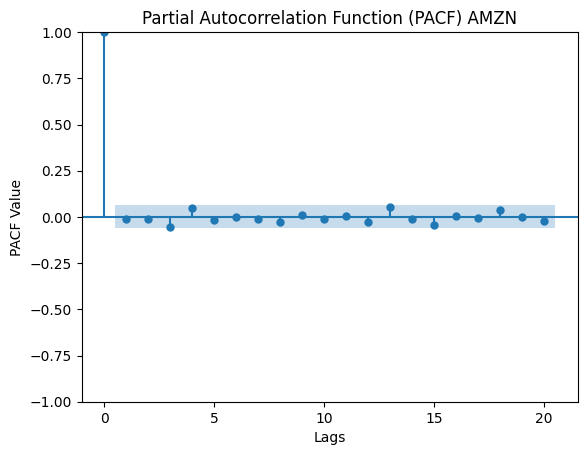

In [46]:
#invoke differenced Data then test for stationarity
def diffDataTestStationarity(dataToTest, n, tickerSymb=""):
    diffData = differencedData(dataToTest["Adj Close"], n)
    diffDta = diffData.dropna()
    stationarityTest(diffDta)
    print('\nNow print the KPSS statistics')
    stationarityKPSS(diffDta)
    plotACF(diffDta, tickerSymb)
    plotPACF(diffDta, tickerSymb)
    
    
diffDataTestStationarity(market_data, 1, '^GSPC')
diffDataTestStationarity(ctsh_market_data, 1, 'CTSH')
diffDataTestStationarity(aapl_market_data, 1, 'AAPL')
diffDataTestStationarity(amzn_market_data, 1, 'AMZN')

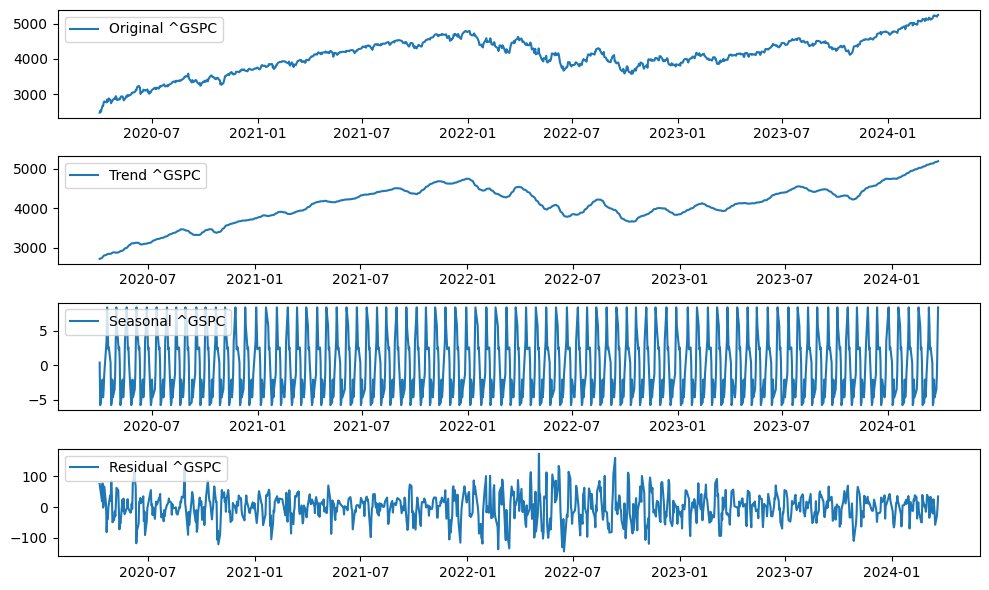

In [29]:
#plot to check for trends or seasonality
def checkSeasonality(testData, model='additive'):
   seasonal_df = seasonal_decompose(testData, model=model, period=12)
   return seasonal_df
result = checkSeasonality(market_data["Adj Close"], model='additive')
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(market_data["Adj Close"], label="Original")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(result.trend, label="Trend")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(result.seasonal, label="Seasonal")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(result.resid, label="Residual")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()



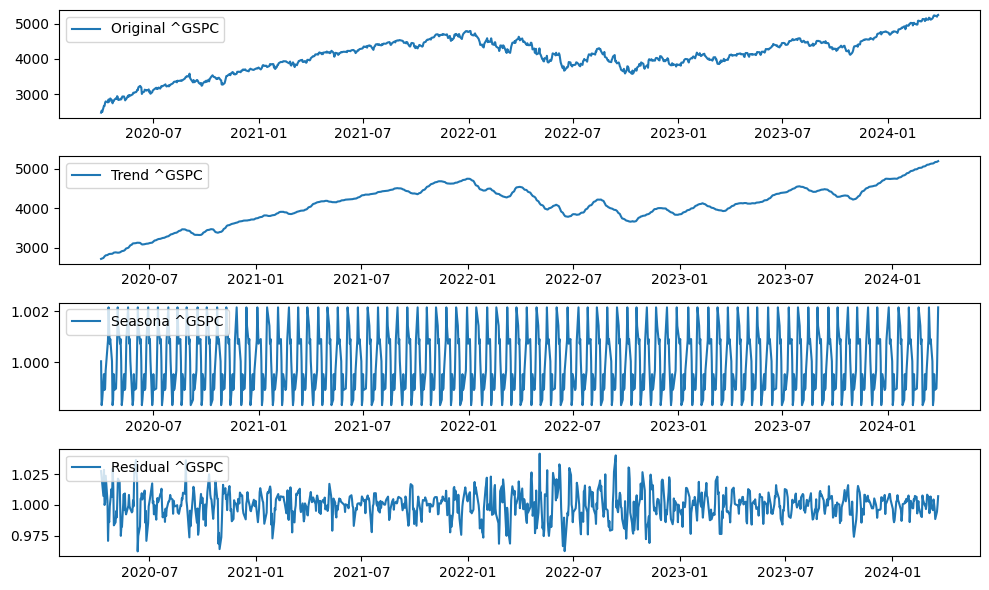

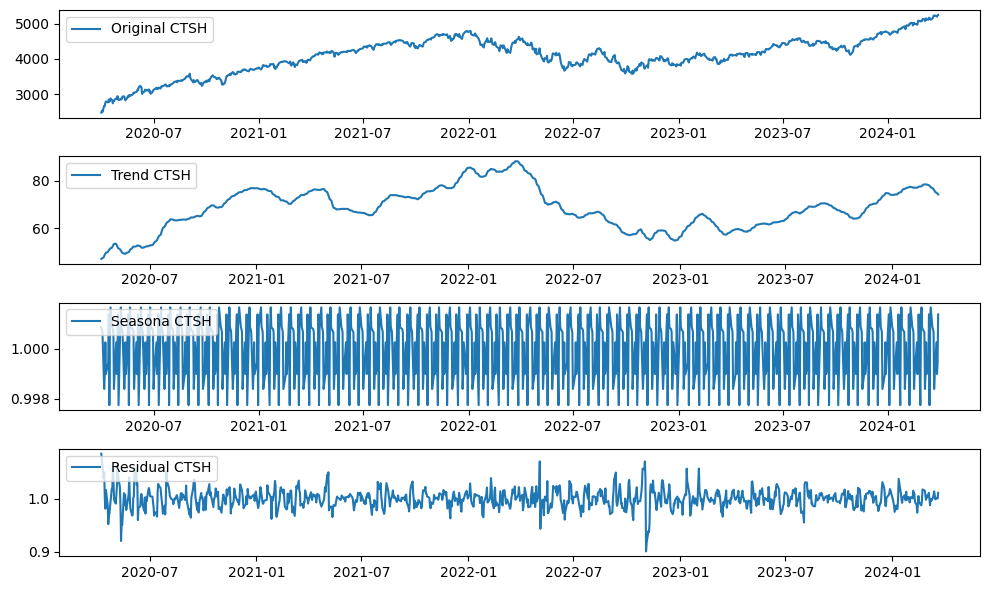

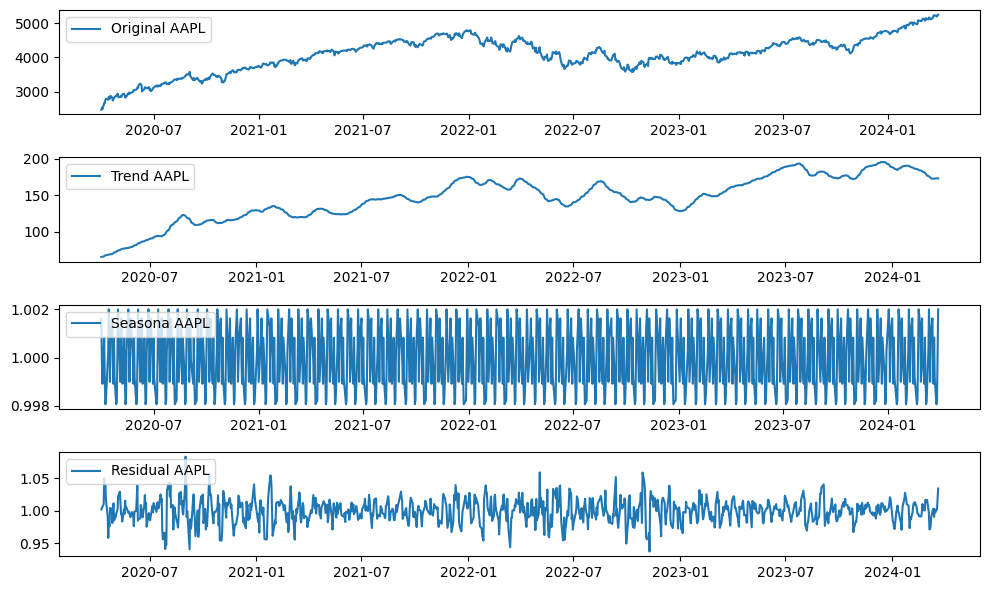

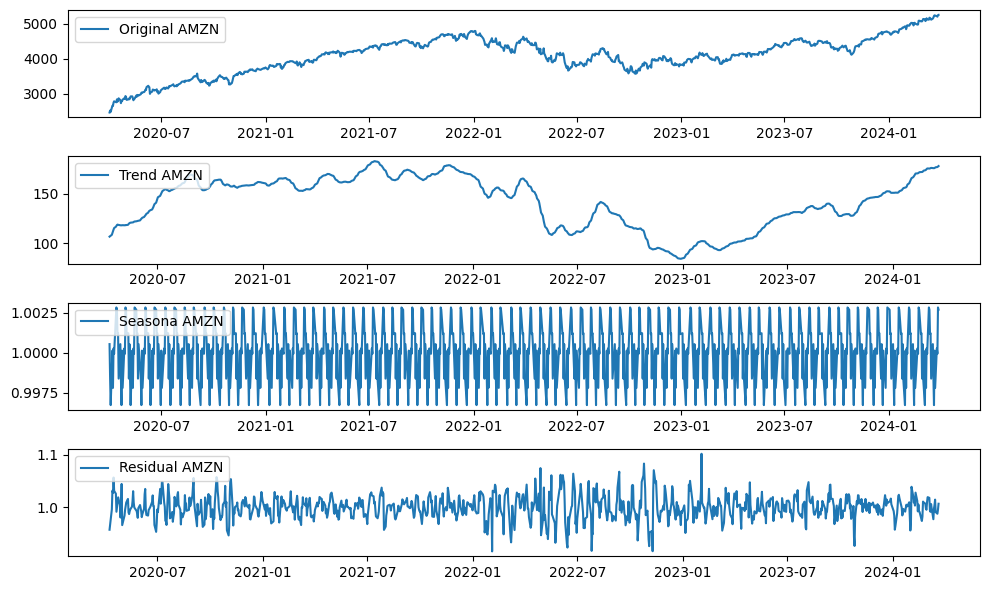

In [33]:


# check for multiplicative seasonality
result = checkSeasonality(market_data["Adj Close"], model='multiplicative')
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(market_data["Adj Close"], label="Original ^GSPC")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(result.trend, label="Trend ^GSPC")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(result.seasonal, label="Seasona ^GSPC")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(result.resid, label="Residual ^GSPC")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

result = checkSeasonality(ctsh_market_data["Adj Close"], model='multiplicative')
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(market_data["Adj Close"], label="Original CTSH")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(result.trend, label="Trend CTSH")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(result.seasonal, label="Seasona CTSH")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(result.resid, label="Residual CTSH")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

result = checkSeasonality(aapl_market_data["Adj Close"], model='multiplicative')
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(market_data["Adj Close"], label="Original AAPL")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(result.trend, label="Trend AAPL")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(result.seasonal, label="Seasona AAPL")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(result.resid, label="Residual AAPL")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

result = checkSeasonality(amzn_market_data["Adj Close"], model='multiplicative')
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(market_data["Adj Close"], label="Original AMZN")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(result.trend, label="Trend AMZN")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(result.seasonal, label="Seasona AMZN")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(result.resid, label="Residual AMZN")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
#plot pacf and eacf of differenced data - gspc, ctsh, aapl , amzn



In [62]:
from sklearn.model_selection import train_test_split
# split the data into test and train data sets, then model the train data set; 
# use the test data for checking the model's accuracy
# do forecasting
# Assuming 'market_data' is your time series data with an index column at index=0
X = market_data.iloc[:, 1:]  # Features (excluding the index column)
y = market_data.iloc[:, 0]   # Target variable (index column)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Note: Ensure that 'shuffle=False' to preserve temporal order

# Optional: Check the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# now train the model by setting P d and Q
# diagnose the p and q values to start the arima

Training set shape: (804, 7) (804,)
Testing set shape: (201, 7) (201,)


In [ ]:
# plot autoarima 

# Import the library 
from pmdarima import auto_arima 
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(market_data["Adj Close"], start_p = 1, start_q = 1, 
                           max_p = 6, max_q = 3, m = 12, 
                           start_P = 0, seasonal = True, 
                           d = None, D = 1, trace = True, 
                           error_action ='ignore',   # we don't want to know if an order does not work 
                           suppress_warnings = True,  # we don't want convergence warnings 
                           stepwise = True)           # set to stepwise 

# stepwise_fit = auto_arima(market_data["Adj Close"].diff().dropna(), d = 1, start_p = 0, start_q = 0)
# To print the summary 
# p-value, AIC, and BIC, all tell us about the goodness of the fit
stepwise_fit.summary() 
stepwise_fit.plot_diagnostics()
# print() # to prevent Jupyter notebooks from printing twice

In [ ]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))

In [ ]:
ax = sns.regplot(market_data, x="date_ordinal", y="Adj Close")
ax.set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
_ = ax.set_xticklabels(new_labels)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(market_data["date_ordinal"], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
X_test.shape

In [ ]:
# Fitting polynomial regression model

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)
poly_x_train = poly.fit_transform(X_train)
poly_x_train.shape

In [ ]:
poly_x_test = poly.transform(X_test)
poly_x_test.shape

In [ ]:
X_train = poly_x_train
X_test = poly_x_test

In [ ]:
# Fitting linear regression model

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

In [ ]:
plt.plot(market_data.iloc[:-30]["date_ordinal"].values.reshape(-1, 1) , y_train)
y_pred = reg.predict(X_train)
plt.plot(market_data.iloc[:-30]["date_ordinal"].values.reshape(-1, 1) , y_pred)
plt.gca().set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
plt.gca().set_xticklabels(new_labels)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))

In [ ]:
# Plotting residuals
y_pred = reg.predict(X_test)
residuals = y_test - y_pred
sns.relplot(x = market_data.iloc[-30:]["date_ordinal"].values.reshape(-1, 1)[:, 0], y = residuals[:, 0], kind="line")

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [ ]:
# Initialize the SPCI class
import SPCI_class as SPCI
SPCI_class_  = SPCI.SPCI_and_EnbPI(
    torch.from_numpy(X_train), 
    torch.from_numpy(X_test), 
    torch.from_numpy(y_train.reshape(-1)), 
    torch.from_numpy(y_test.reshape(-1)), 
    fit_func=reg)
stride = 1
SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

In [ ]:
past_window = 30
use_SPCI = True
smallT = not use_SPCI
SPCI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=True, stride=stride)
results = SPCI_class_.get_results(alpha, 'my_data', 1)

In [ ]:
# Plot prediction intervals on test sample
Pred_ints = SPCI_class_.PIs_Ensemble
Y_est = SPCI_class_.Ensemble_pred_interval_centers
Y_predict = SPCI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')